In [ ]:
!pip install fastai
!pip install torch
!pip install --upgrade torch
!pip install --upgrade fastai

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from fastai.tabular.all import *
from fastai.learner import Learner
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from google.colab import drive
from pathlib import Path
import seaborn as sns

def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2




In [ ]:

drive.mount('/content/drive')

#Load data
path = Path("/content/drive/My Drive/spotify_songs.csv")


Mounted at /content/drive


In [ ]:


# Load the dataset
data = pd.read_csv(path)
data = data.head(10000) #only use 10,000 rows



Here we use one hot encoding. Consider trying alternative methods.

When feature scaling, consider alternative method of scaling.

In [ ]:
# Drop unnecessary columns
X = pd.get_dummies(data.drop(['track_popularity', 'track_id', 'track_name', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id'], axis=1))
y = data['track_popularity']

# Split the data into training and testing sets 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)



[[0.88188529 0.72851866 0.90909091 ... 0.         0.         0.        ]
 [0.31629756 0.64878994 0.36363636 ... 1.         0.         0.        ]
 [0.2322544  0.58823648 1.         ... 1.         0.         0.        ]
 ...
 [0.53776263 0.79613669 0.45454545 ... 0.         0.         0.        ]
 [0.55706985 0.58924571 0.63636364 ... 0.         0.         0.        ]
 [0.42986939 0.78200755 0.90909091 ... 0.         1.         0.        ]]


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I tried allow the processes to be run on GPU but it still takes an obscene amount of time.


In [ ]:
# Feature selection using Recursive Feature Elimination (RFE)
estimator = RandomForestRegressor(n_estimators=200, random_state=42)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

# Get selected features
selected_features = X.columns[selector.support_]

# Apply feature selection
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]



In [ ]:
print(X_train_selected)

In [ ]:
=

#regressors initialize
regressors = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Support Vector Machine': SVR(kernel='linear'),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}
# grid search, specify which param configs you want to test.
param_grid = {
    'Random Forest': {'n_estimators': [325,350,375,400], 'criterion':['squared_error','absolute_error','friedman_mse']},
    'Support Vector Machine': {'kernel': ['linear', 'rbf','sigmoid','poly'], 'gamma': ['scale','auto'], 'C': [1.0,2.0,3.0]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'loss':['squared_error','absolute_error']}
}

#for each, do grid search, then evaluate with best params (as defined by grid).
for name, reg in regressors.items():

    grid_search = GridSearchCV(reg, param_grid[name], scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_selected, y_train)
    best_reg = grid_search.best_estimator_
    y_pred = best_reg.predict(X_test_selected)


    # Evaluate the model
    mae, mse, rmse, r2 = evaluate_regression(y_test, y_pred)

    print(f'Regressor: {name}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R-squared: {r2}')

    # Plotting the results
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

    print('------------------------------------------------------------------------------')

# Second Attempt

In [ ]:
# Load the data
path = "/content/drive/My Drive/spotify_songs.csv"
data = pd.read_csv(path)
#data = data.head(10000) # Only use 10,000 rows

# Assuming 'popularity' is the column name containing popularity scores in your DataFrame
filtered_data = data[data['track_popularity'] >= 15]

# Define the target variable
dep_var_name = 'track_popularity'

# Define the preprocessing steps
procs = [Categorify, FillMissing, Normalize]

# Define the continuous variable names
cont_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
              'duration_ms']

# Define the categorical variable names
cat_names = ['track_id', 'track_name', 'track_artist', 'track_album_id',
             'track_album_name', 'track_album_release_date', 'playlist_name',
             'playlist_id', 'playlist_genre', 'playlist_subgenre']


# Create TabularPandas object.... randomsplitter by default does 80-20 split
to = TabularPandas(filtered_data, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=dep_var_name, splits=RandomSplitter()(range_of(filtered_data)))


# Count unique values in the 'genre' column
unique_genre_count = to['playlist_genre'].nunique()
print("Number of unique genres:", unique_genre_count)


Number of unique genres: 6


(4/19)

Above, I dont believe i have eliminated any features from the dataset. I think it is logical to assume it may help performance to try and eliminate some that probably have no effect on prediction.

I actually did try this! and it actually hurt performance.

After looking at popularity distribution, i noticed that a large quantity of the songs had 0-20 popularity score. I removed the tail end of the data and it showed a decrease in error and improved r2.


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(22526, 1000)
    (1): Embedding(19373, 1000)
    (2): Embedding(9232, 1000)
    (3): Embedding(18172, 1000)
    (4): Embedding(16455, 1000)
    (5): Embedding(3908, 1000)
    (6): Embedding(450, 1000)
    (7): Embedding(472, 1000)
    (8): Embedding(7, 1000)
    (9): Embedding(25, 1000)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=2152, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
  

SuggestedLRs(valley=0.02290867641568184)

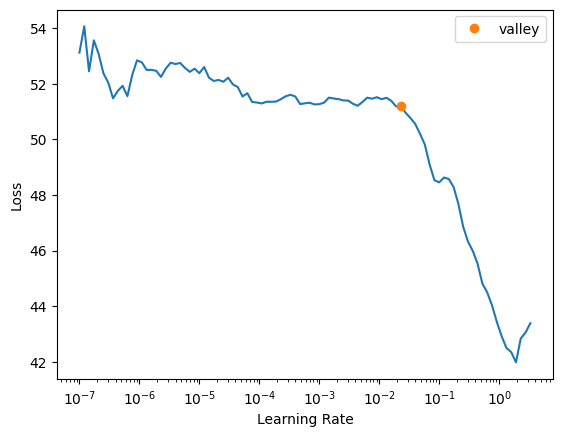

In [ ]:
# Define the embedding sizes for categorical variables
emb_szs = get_emb_sz(to)

# Define the architecture of the TabularModel
model = TabularModel(emb_szs=emb_szs, n_cont=len(cont_names), out_sz=1, layers=[200, 100], ps=[0.1, 0.0])

# Increase the size of all embeddings to 1000
for i, embedding in enumerate(model.embeds):
    embedding.embedding_dim = 1000


# Print the model architecture
print(model)

# Define the dataloaders
dls = to.dataloaders(bs=32)

# Define the learner
learn = Learner(dls, model, loss_func=L1LossFlat(), metrics=[mse, R2Score()], cbs=[ShowGraphCallback(), EarlyStoppingCallback(patience=10)])

# Find the optimal learning rate
learn.lr_find()


epoch,train_loss,valid_loss,mse,r2_score,time
0,11.449631,10.478352,177.678543,0.457050,00:16
1,9.138474,9.244413,138.788513,0.575891,00:16
2,7.501506,8.731801,133.704575,0.591426,00:16
3,6.487791,8.718927,131.736740,0.597439,00:16
4,6.116525,8.589405,125.809151,0.615553,00:16
5,5.424008,8.570569,132.263138,0.595831,00:16
6,5.887405,8.715487,135.447769,0.586099,00:16
7,5.544793,8.288806,125.404114,0.616791,00:16
8,5.033997,8.088793,120.876907,0.630625,00:17
9,4.750438,8.680294,134.895157,0.587788,00:16


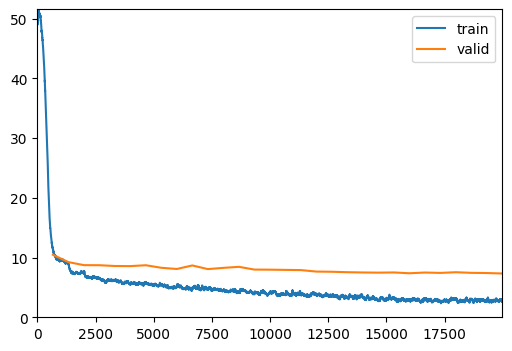

In [ ]:
# Train the model
learn.fit_one_cycle(30, 0.02290867641568184)


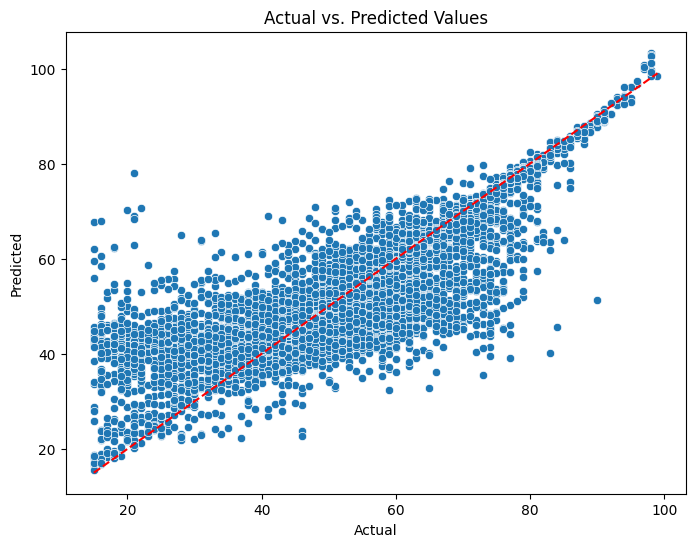

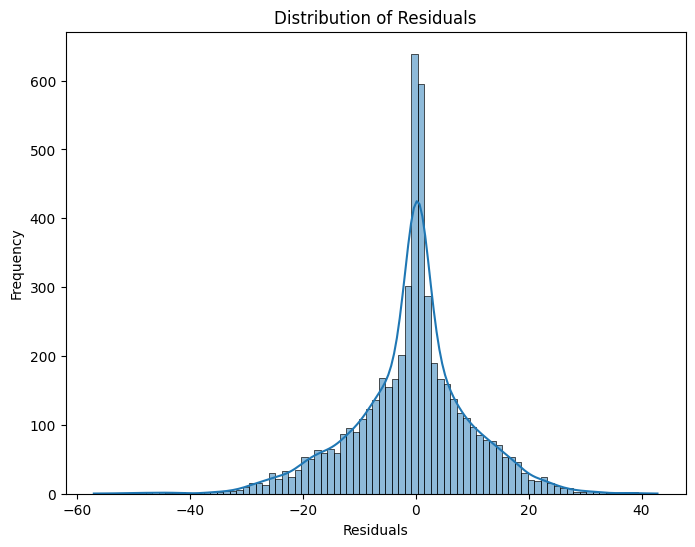

In [ ]:

#Actual vs. Predicted Values Plot
preds, targets = learn.get_preds()
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()  # Flatten to ensure 1-dimensional arrays
plt.figure(figsize=(8, 6))
sns.scatterplot(x=targets, y=preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--')  # Diagonal line for perfect prediction
plt.show()

#Residual Plot
residuals = targets - preds
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

Best so far!

with layers = 200,100
lr = 0.05754

```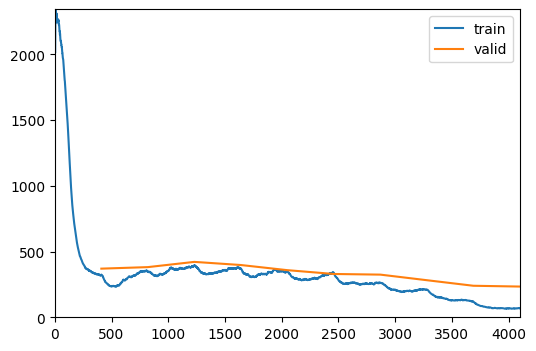
epoch	train_loss	valid_loss	mse	r2_score	time
0	315.260925	298.763733	298.763733	0.530188	00:06
1	162.377884	272.194916	272.194916	0.571968	00:06
2	95.278931	281.482513	281.482513	0.557363	00:06
3	49.878227	248.206421	248.206421	0.609690	00:06
4	29.701258	245.698654	245.698654	0.613634	00:06
```




(4/19)

However, the magnitude of difference in loss suggests were over fitting. (valid loss>training). We have relu, but i guess we need even more regularization. OR a simpler model. I have added weight decay in the training loop and dropout in the linear layers.

(4/22)

A new Best. Here, losses are closer and we may even need to increase epochs to let it continue learning.

lr = 0.08, wd=0.2

```


epoch	train_loss	valid_loss	mse	r2_score	time
0	323.554199	370.095734	370.095734	0.404160	00:12
1	349.652954	381.682312	381.682312	0.385506	00:12
2	392.395569	421.524170	421.524170	0.321362	00:12
3	370.590454	397.665283	397.665283	0.359774	00:12
4	350.888611	358.487671	358.487671	0.422849	00:12
5	339.599304	329.477539	329.477539	0.469554	00:12
6	261.937073	324.561310	324.561310	0.477469	00:12
7	209.080750	282.062042	282.062042	0.545891	00:12
8	119.809120	239.821976	239.821976	0.613896	00:12
9	68.693748	233.770172	233.770172	0.623639	00:12
```

Ive taken away the weight decay, and switched the loss funciton to L1 or MeanAverageError, upped our patience and epochs

```
epoch	train_loss	valid_loss	mse	r2_score	time
0	14.655374	13.145295	306.780670	0.507372	00:06
1	10.547555	12.871758	294.639435	0.526868	00:06
2	9.623315	14.185433	501.942139	0.193981	00:06
3	9.359549	13.028844	316.578583	0.491638	00:06
4	9.379193	15.685735	391.177856	0.371847	00:06
5	8.879535	13.799999	313.511719	0.496563	00:06
6	8.230397	13.755601	319.023865	0.487712	00:06
7	7.576258	11.856209	268.186676	0.569346	00:06
8	7.207969	11.900524	287.289673	0.538670	00:06
9	7.192554	11.826774	276.082184	0.556667	00:06
10	6.413722	11.903085	280.021667	0.550341	00:06
11	5.970960	11.921476	275.557556	0.557510	00:06
12	5.630351	11.156443	265.618927	0.573469	00:06
13	5.090155	10.925785	243.965332	0.608241	00:06
14	4.517993	10.828912	255.708740	0.589383	00:06
15	4.312867	10.491940	237.439987	0.618719	00:06
16	3.542664	10.234328	230.472733	0.629907	00:06
17	3.175454	10.210774	237.713501	0.618280	00:06
18	3.069021	10.254963	240.454422	0.613878	00:06
19	3.102257	10.376889	237.555344	0.618534	00:06
```

New record (4/24)

```
epoch	train_loss	valid_loss	mse	r2_score	time
0	10.947739	10.533143	184.771774	0.452409	00:16
1	9.089035	9.224443	148.586929	0.559647	00:16
2	6.998212	9.120266	145.200745	0.569682	00:16
3	6.585295	9.313548	158.148453	0.531311	00:16
4	6.108523	8.938370	141.522217	0.580584	00:16
5	6.207332	9.840893	165.634064	0.509126	00:16
6	5.651221	8.803113	137.602936	0.592199	00:16
7	5.413588	9.584910	167.325150	0.504115	00:16
8	5.378374	8.468724	131.435059	0.610478	00:16
9	4.980009	8.320586	130.549164	0.613104	00:16
10	4.698735	8.488416	126.521553	0.625040	00:17
11	4.863050	8.235067	126.221085	0.625931	00:16
12	4.625796	8.401166	136.623764	0.595101	00:16
13	4.560423	8.520554	145.414566	0.569049	00:16
14	4.246871	7.986291	122.761795	0.636182	00:16
15	4.031298	7.978594	121.516869	0.639872	00:16
16	4.310482	7.760572	118.897614	0.647635	00:16
17	3.785820	8.121045	123.804291	0.633093	00:16
18	3.861109	7.711392	117.122223	0.652896	00:16
19	3.810237	7.760774	120.427963	0.643099	00:16
20	3.262500	7.570906	115.787186	0.656853	00:16
21	3.245260	7.589879	115.504417	0.657691	00:16
22	3.472243	7.719013	118.398361	0.649114	00:16
23	3.309793	8.375313	130.790680	0.612388	00:16
24	2.823447	7.437298	114.275291	0.661333	00:16
25	2.856570	7.362502	112.306358	0.667168	00:16
```

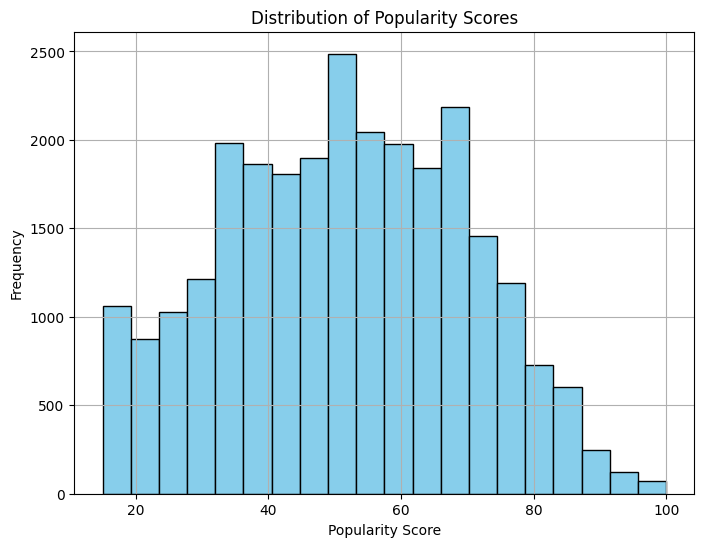

In [ ]:
popularity_values = filtered_data['track_popularity']

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(popularity_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Popularity Scores')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

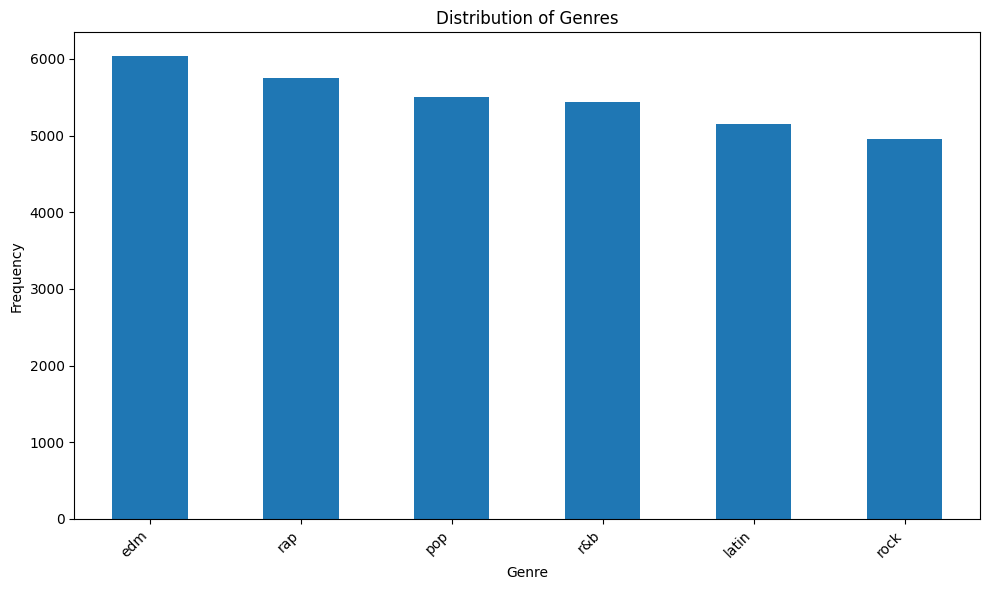

In [ ]:
# Plot the distribution of genres
plt.figure(figsize=(10, 6))
data['playlist_genre'].value_counts().plot(kind='bar')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Extra Analysis (Nick's Attempts)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# def load_data(file_path):
#     return pd.read_csv(file_path)

def preprocess_data(data):
    data = pd.get_dummies(data, columns=['playlist_genre', 'playlist_subgenre'])
    X = data.drop(['track_popularity', 'track_id', 'track_name', 'track_artist', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id'], axis=1)
    y = data['track_popularity']  # Continuous target variable for regression
    return X, y

def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def select_features(X_train_scaled, y_train, estimator, n_features_to_select=3):
    if hasattr(estimator, 'coef_'):
        selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
        selector.fit(X_train_scaled, y_train)
        selected_features = selector.support_
    else:
        # If estimator does not have coef_ attribute (like SVR), select all features
        selected_features = [True] * X_train_scaled.shape[1]

    return selected_features

def train_random_forest(X_train_scaled, y_train):
    reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    reg_rf.fit(X_train_scaled, y_train)
    return reg_rf

def train_gradient_boosting(X_train_scaled, y_train):
    reg_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
    reg_gb.fit(X_train_scaled, y_train)
    return reg_gb

def train_svm(X_train_scaled, y_train):
    reg_svm = SVR(kernel='rbf', gamma='scale')
    reg_svm.fit(X_train_scaled, y_train)
    return reg_svm

def train_linear_regression(X_train_scaled, y_train):
    reg_lr = LinearRegression()
    reg_lr.fit(X_train_scaled, y_train)
    return reg_lr

def train_elastic_net(X_train_scaled, y_train):
    reg_en = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    reg_en.fit(X_train_scaled, y_train)
    return reg_en

def train_lasso(X_train_scaled, y_train):
    reg_lasso = Lasso(alpha=0.1, random_state=42)
    reg_lasso.fit(X_train_scaled, y_train)
    return reg_lasso

def train_ridge(X_train_scaled, y_train):
    reg_ridge = Ridge(alpha=0.1, random_state=42)
    reg_ridge.fit(X_train_scaled, y_train)
    return reg_ridge

def train_knn(X_train_scaled, y_train):
    reg_knn = KNeighborsRegressor()
    reg_knn.fit(X_train_scaled, y_train)
    return reg_knn

def train_decision_tree(X_train_scaled, y_train):
    reg_dt = DecisionTreeRegressor()
    reg_dt.fit(X_train_scaled, y_train)
    return reg_dt

def train_xgboost(X_train_scaled, y_train):
    reg_xgb = XGBRegressor(objective ='reg:squarederror', random_state=42)
    reg_xgb.fit(X_train_scaled, y_train)
    return reg_xgb

def train_neural_network(X_train_scaled, y_train):
    reg_nn = MLPRegressor(random_state=42)
    reg_nn.fit(X_train_scaled, y_train)
    return reg_nn

def evaluate_regressor(reg, X_test_scaled, y_test):
    y_pred = reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, r2, mae

def main():
    data = pd.read_csv(path)
    data_subset = data.head(10000)

    X, y = preprocess_data(data_subset)
    X_train, X_test, y_train, y_test = split_data(X, y)
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    print("")
    print("Selecting Features....")

    # Random Forest
    selected_features_rf = select_features(X_train_scaled, y_train, RandomForestRegressor(n_estimators=100, random_state=42))
    X_train_selected_rf = X_train_scaled[:, selected_features_rf]
    X_test_selected_rf = X_test_scaled[:, selected_features_rf]

    # Gradient Boosting
    selected_features_gb = select_features(X_train_scaled, y_train, GradientBoostingRegressor(n_estimators=100, random_state=42))
    X_train_selected_gb = X_train_scaled[:, selected_features_gb]
    X_test_selected_gb = X_test_scaled[:, selected_features_gb]

    # SVM
    selected_features_svm = select_features(X_train_scaled, y_train, SVR(kernel='rbf', gamma='scale'))
    X_train_selected_svm = X_train_scaled[:, selected_features_svm]
    X_test_selected_svm = X_test_scaled[:, selected_features_svm]

    # Linear Regression
    selected_features_lr = select_features(X_train_scaled, y_train, LinearRegression())
    X_train_selected_lr = X_train_scaled[:, selected_features_lr]
    X_test_selected_lr = X_test_scaled[:, selected_features_lr]

    # Elastic Net
    selected_features_en = select_features(X_train_scaled, y_train, ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
    X_train_selected_en = X_train_scaled[:, selected_features_en]
    X_test_selected_en = X_test_scaled[:, selected_features_en]

    # Lasso
    selected_features_lasso = select_features(X_train_scaled, y_train, Lasso(alpha=0.1, random_state=42))
    X_train_selected_lasso = X_train_scaled[:, selected_features_lasso]
    X_test_selected_lasso = X_test_scaled[:, selected_features_lasso]

    # Ridge
    selected_features_ridge = select_features(X_train_scaled, y_train, Ridge(alpha=0.1, random_state=42))
    X_train_selected_ridge = X_train_scaled[:, selected_features_ridge]
    X_test_selected_ridge = X_test_scaled[:, selected_features_ridge]

    # K-Nearest Neighbors
    selected_features_knn = select_features(X_train_scaled, y_train, KNeighborsRegressor())
    X_train_selected_knn = X_train_scaled[:, selected_features_knn]
    X_test_selected_knn = X_test_scaled[:, selected_features_knn]

    # Decision Tree
    selected_features_dt = select_features(X_train_scaled, y_train, DecisionTreeRegressor())
    X_train_selected_dt = X_train_scaled[:, selected_features_dt]
    X_test_selected_dt = X_test_scaled[:, selected_features_dt]

    # XGBoost
    selected_features_xgb = select_features(X_train_scaled, y_train, XGBRegressor(objective='reg:squarederror', random_state=42))
    X_train_selected_xgb = X_train_scaled[:, selected_features_xgb]
    X_test_selected_xgb = X_test_scaled[:, selected_features_xgb]

    # Neural Network
    selected_features_nn = select_features(X_train_scaled, y_train, MLPRegressor(random_state=42))
    X_train_selected_nn = X_train_scaled[:, selected_features_nn]
    X_test_selected_nn = X_test_scaled[:, selected_features_nn]

    # Training and evaluation for each model type
    model_reg_list = [
        (train_random_forest, X_train_selected_rf, y_train, X_test_selected_rf, y_test),
        (train_gradient_boosting, X_train_selected_gb, y_train, X_test_selected_gb, y_test),
        (train_svm, X_train_selected_svm, y_train, X_test_selected_svm, y_test),
        (train_linear_regression, X_train_selected_lr, y_train, X_test_selected_lr, y_test),
        (train_elastic_net, X_train_selected_en, y_train, X_test_selected_en, y_test),
        (train_lasso, X_train_selected_lasso, y_train, X_test_selected_lasso, y_test),
        (train_ridge, X_train_selected_ridge, y_train, X_test_selected_ridge, y_test),
        (train_knn, X_train_selected_knn, y_train, X_test_selected_knn, y_test),
        (train_decision_tree, X_train_selected_dt, y_train, X_test_selected_dt, y_test),
        (train_xgboost, X_train_selected_xgb, y_train, X_test_selected_xgb, y_test),
        (train_neural_network, X_train_selected_nn, y_train, X_test_selected_nn, y_test)
    ]

    for train_func, X_train_sel, y_train, X_test_sel, y_test in model_reg_list:
        print("")
        model_name = train_func.__name__[6:].replace('_', ' ').capitalize()
        print(f"Training {model_name}...")
        reg_model = train_func(X_train_sel, y_train)

        print(f"Evaluating {model_name}...")
        mse, r2, mae = evaluate_regressor(reg_model, X_test_sel, y_test)

        print(f"{model_name}:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")
        print(f"Mean Absolute Error: {mae}")
        print("")
        print('---------------------------------------')

if __name__ == "__main__":
    main()


Selecting Features....

Training Random forest...


KeyboardInterrupt: 